In [1]:
 #필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf
import PIL
import skimage
import albumentations


from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

2.6.0
1.21.4
8.3.2
0.18.3
1.1.0


In [2]:
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                        HorizontalFlip(p=0.5),    # 50% 확률로 이미지를 좌우로 대칭 변환
                        RandomSizedCrop(          # 50% 확률로 일정한 크기로 무작위 크롭
                            min_max_height=(300, 370),  # 최소 높이 300, 최대 높이 370 픽셀 범위에서 크롭
                            w2h_ratio=370/1242,         # 너비와 높이의 비율을 유지
                            height=224,                 # 최종 크기를 224x224로 맞춤
                            width=224,
                            p=0.5
                        ),
                        Resize(                      # 크기를 224x224로 리사이즈
                            width=224,
                            height=224
                        )
                      ])
    return Compose([  # 테스트용 데이터일 경우
                Resize(     # 리사이즈만 적용하여 이미지를 224x224로 만듦
                    width=224,
                    height=224
                )
           ])

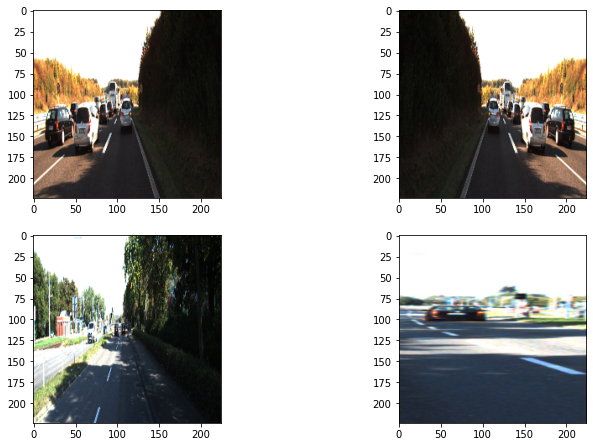

In [4]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(2):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

In [3]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
              "image": _input,
              "mask": _output,
              }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [19]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

모델 만들기

In [6]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, Input
# from tensorflow.keras.models import Model

def build_model(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D((2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, (3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

Unet 모델 학습

In [ ]:

# 모델 학습

model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')

# ModelCheckpoint 콜백을 추가하여 최상의 모델만 저장
checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


early_stopping = EarlyStopping(
    monitor='val_loss',   # 'val_loss'를 모니터링하여 조기 종료 여부 결정
    patience=3,          # 10 epochs 동안 개선되지 않으면 종료
    verbose=1,
    restore_best_weights=True  # 최적의 가중치로 복원하여 종료
)

model.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    callbacks=[checkpoint, early_stopping]  # 콜백 리스트에 checkpoint 추가
    
 )


model.save(model_path)  #학습한 모델을 저장해 주세요.

Unet++ 모델 학습

In [12]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)
    
    # Encoder path with dense skip connections
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D((2, 2))(drop4)

    # Bottleneck layer
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder path with dense skip connections
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [38]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# 모델 학습
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')

# ModelCheckpoint 콜백을 추가하여 최상의 모델만 저장
checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor='val_loss',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',   # 'val_loss'를 모니터링하여 조기 종료 여부 결정
    patience=3,          # 10 epochs 동안 개선되지 않으면 종료
    verbose=1,
    restore_best_weights=True  # 최적의 가중치로 복원하여 종료
)

model.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    callbacks=[checkpoint, early_stopping]  # 콜백 리스트에 checkpoint 추가
    
 )


model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 8s 576ms/step - loss: 0.6872 - val_loss: 0.6746

Epoch 00001: saving model to /aiffel/aiffel/semantic_segmentation/seg_model_unet_plus.h5
Epoch 2/100
11/11 [==============================] - 6s 552ms/step - loss: 0.6203 - val_loss: 0.3806

Epoch 00002: saving model to /aiffel/aiffel/semantic_segmentation/seg_model_unet_plus.h5
Epoch 3/100
11/11 [==============================] - 6s 550ms/step - loss: 0.1990 - val_loss: 0.2819

Epoch 00003: saving model to /aiffel/aiffel/semantic_segmentation/seg_model_unet_plus.h5
Epoch 4/100
11/11 [==============================] - 6s 531ms/step - loss: 0.1937 - val_loss: 0.2819

Epoch 00004: saving model to /aiffel/aiffel/semantic_segmentation/seg_model_unet_plus.h5
Epoch 5/100
11/11 [==============================] - 6s 536ms/step - loss: 0.1991 - val_loss: 0.2819

Epoch 00005: saving model to /aiffel/aiffel/semantic_segmentation/seg_model_unet_plus.h5
Epoch 6/100
11/11 [==========================

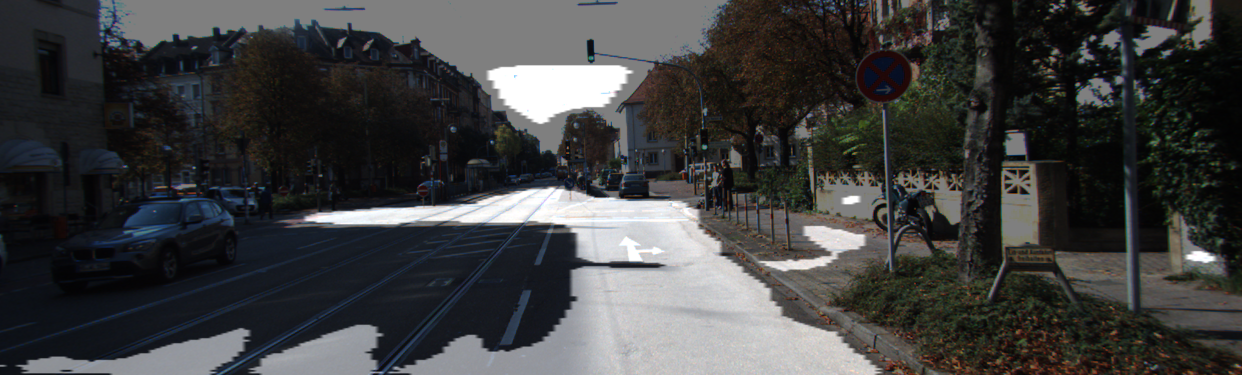

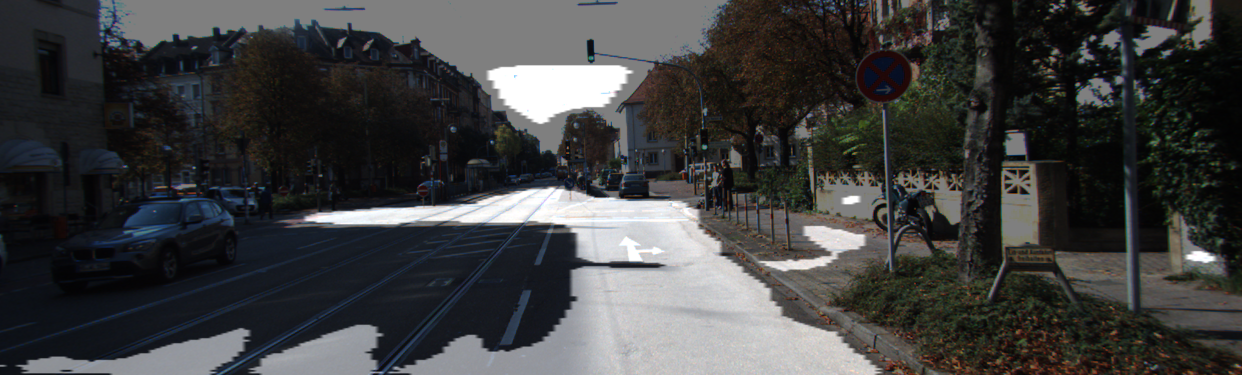

In [14]:
# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
model_path = dir_path + '/seg_model_unet.h5' 

model = tf.keras.models.load_model(model_path)


def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output


# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [9]:
def calculate_iou_score(target, prediction):
    # 두 행렬에서 교집합과 합집합을 구합니다.
    intersection = np.logical_and(target, prediction).sum()  # 교집합 영역의 픽셀 개수
    union = np.logical_or(target, prediction).sum()  # 합집합 영역의 픽셀 개수
    
    # IoU 스코어 계산
    iou_score = float(intersection) / float(union) if union != 0 else 1.0
    print('IoU : %f' % iou_score)
    
    return iou_score


In [16]:
def get_output(model, preproc, image_path, output_path, label_path):
    # 원본 이미지를 불러옵니다.
    origin_img = imread(image_path)
    data = {"image": origin_img}
    
    # 전처리 함수를 통해 이미지를 전처리합니다.
    processed = preproc(**data)
    
    # 모델에 전처리된 이미지를 입력하여 예측 결과를 얻습니다.
    # 0~1 사이의 값을 가지므로 255로 나누고 차원을 추가하여 배치 처리 형태로 만듭니다.
    output = model(np.expand_dims(processed["image"] / 255, axis=0))
    
    # 예측 결과를 0.5를 임계값(threshold)으로 하여 0과 1의 이진 형태로 변환하고
    # 도로로 인식한 영역을 255로 변환하여 흑백 이미지 형태로 만듭니다.
    output = (output[0].numpy() >= 0.5).astype(np.uint8).squeeze(-1) * 255
    
    # 예측된 도로 영역을 0과 1의 값으로 변환하여 도로로 판단한 영역으로 설정합니다.
    prediction = output / 255
    
    # numpy 배열을 PIL 이미지로 변환하여 도로 영역 이미지를 생성합니다.
    output = Image.fromarray(output)
    
    # 원본 이미지를 RGBA 포맷으로 변환하여 배경으로 설정합니다.
    background = Image.fromarray(origin_img).convert('RGBA')
    
    # 예측 결과 이미지를 원본 이미지 크기로 리사이즈하고, RGBA 포맷으로 변환합니다.
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    
    # 배경과 예측 결과 이미지를 블렌딩하여 시각화된 결과를 생성합니다.
    output = Image.blend(background, output, alpha=0.5)
    output.show()  # 도로로 판단한 영역을 시각화하여 보여줍니다.
     
    # 라벨이 있는 경우 라벨 데이터를 처리하여 도로 영역을 계산합니다.
    if label_path:
        label_img = imread(label_path)
        label_data = {"image": label_img}
        
        # 전처리 함수를 사용하여 라벨 데이터를 전처리합니다.
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        
        # 도로 영역을 나타내는 라벨이 7인 경우, 도로 영역을 이진 형태로 변환합니다.
        target = (label_processed == 7).astype(np.uint8) * 1  # 도로로 판단한 라벨 영역
        
        # 결과로 output 이미지, 예측된 도로 영역 prediction, 실제 도로 영역 target을 반환합니다.
        return output, prediction, target
    else:
        # 라벨이 없는 경우 output과 prediction만 반환합니다.
        return output, prediction, _

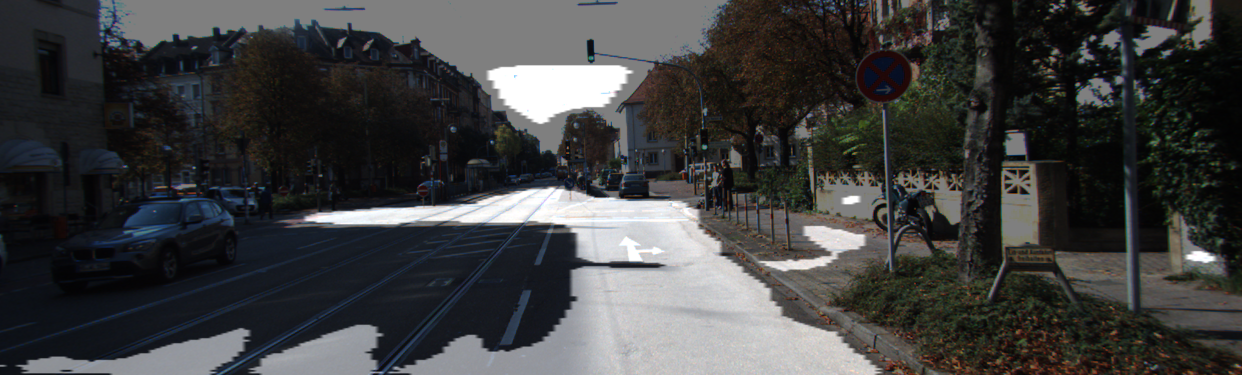

IoU : 0.419641


0.41964089410040306

In [17]:
# 시각화한 결과 확인  - Unet
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

In [40]:
model.history['val_loss']

TypeError: 'NoneType' object is not subscriptable

In [34]:
target

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=uint8)

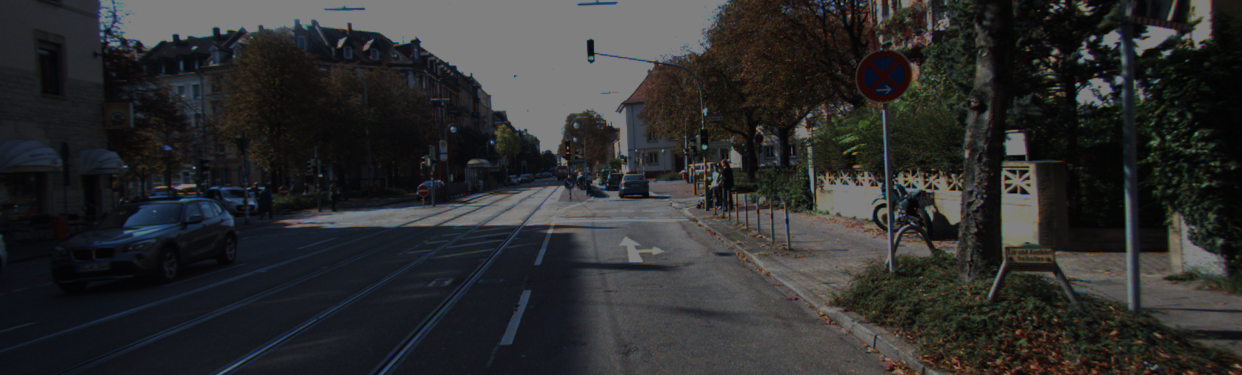

IoU : 0.000000


0.0

In [39]:
# 시각화한 결과 확인  - Unet++
# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus.h5'

model = tf.keras.models.load_model(model_path)

output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

In [6]:
PATH_HOME = os.getenv('HOME')
PATH_PROJ = DIR_HOME + ('/sementic_segmentation')
PATH_TRAIN_DATA = DIR_PROJ + ('data/training')
PATH_TEST_DATA = DIR_PROJ + ('data/testing')